In [85]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import spacy
import unicodedata
import nltk
nltk.download('stopwords')
import re
from nltk.tokenize.toktok import ToktokTokenizer
import re
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
#reading the csv file
url = 'https://raw.githubusercontent.com/credit110/Data-Science/main/Tweets.csv'
data = pd.read_csv(url)

In [3]:
#View the columns in the csv file
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [24]:
#Keep the required columns
data = data [['text','airline_sentiment']]

In [ ]:
#Shape of the data
data.shape

(14640, 2)

In [ ]:
#Printing first 5 rows from the data
data.head(5) 

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [25]:
#Using BeautifulSoup lib to remove any HTML tags
data['text'] = [BeautifulSoup(text).get_text() for text in data['text']]

In [ ]:
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [26]:
#Remove accented characters from the text
data['text'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
data['text'].iloc[6]

'@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)'

In [27]:
#Remove the stop words from the 'text' column
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.remove('nor')
stopword_list.append('@')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword_list)]))

In [32]:
#Preprocess the data. Individual comments in-line with individual functions below
def preprocess(text):
    clean_data = []
    for x in (text[:]):
        new_text = re.sub(r'[^\w\s]', '', x) # remove punc.
        new_text = re.sub(r'\d+','',new_text)# remove numbers
        new_text = re.sub(r'[^a-zA-z\s]','',new_text) #remove special characters
        new_text = new_text.lower() # lower case, .upper() for upper
        if new_text != '':
            clean_data.append(new_text)
    return clean_data
data['text'] = preprocess(data['text'])
data['text'].head()

0                     virginamerica what dhepburn said
1    virginamerica plus added commercials experienc...
2    virginamerica i today must mean i need take an...
3    virginamerica really aggressive blast obnoxiou...
4                   virginamerica really big bad thing
Name: text, dtype: object

In [37]:
#remove numbers
data.loc[:,"text"] = data.text.apply(lambda x : " ".join(re.findall('[\w]+',x)))

In [44]:
#Lemitization and Tokenization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

data['text'] = data.text.apply(lemmatize_text)

In [56]:
#Join the words in the list to convert back to text string in the data frame
for count,sentence in enumerate(data.text[:]):
    data.text[count] = TreebankWordDetokenizer().detokenize(sentence)
#Print the first 5 rows of data after pre-processing.
data.head()

,text,airline_sentiment
0,virginamerica what dhepburn said,neutral
1,virginamerica plus added commercial experience...,positive
2,virginamerica i today must mean i need take an...,neutral
3,virginamerica really aggressive blast obnoxiou...,negative
4,virginamerica really big bad thing,negative


In [64]:
#Vectorization using the TfidfVextorizer

def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector
tf_vector = get_feature_vector(np.array(data.iloc[:, 0]).ravel())
  

In [67]:
#Converting the vectorzied values to array in X; Splitting the data in testing and training
X = tf_vector.transform(np.array(data.iloc[:, 0]).ravel())
y = np.array(data.iloc[:, 1]).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [68]:
#Fit the data over Naive Bayes model and print the accuracy
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print(accuracy_score(y_test, y_predict_nb))

0.6782786885245902


In [71]:
#Fir the data over Logistic Regression with a multiclass classifier and printing the accuracy of the model
LR_model = LogisticRegression(multi_class='multinomial',max_iter=150)
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

0.7943989071038251


In [73]:
#Printing the confusion matrix
conf_mat = confusion_matrix(y_test, y_predict_lr)

print(conf_mat)

[[1742   79   14]
 [ 279  322   32]
 [ 132   66  262]]


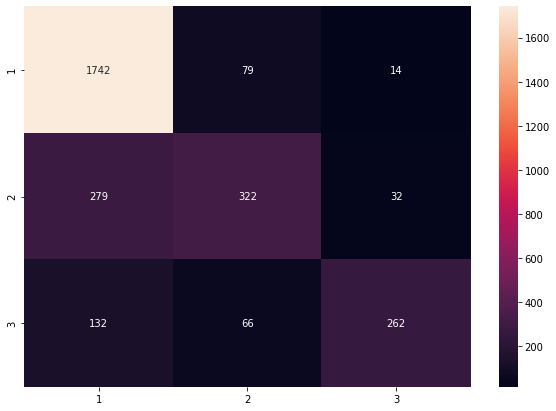

In [75]:
#Visualize the confusion matrix
df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [78]:
#Vectorization using CountVectorizer

vectorizer = CountVectorizer(max_features=1000)
data_features = vectorizer.fit_transform(data['text'])

data_features = data_features.toarray()

In [83]:
#Saving the y variable in a variable names labels
labels = data['airline_sentiment']

In [84]:
#Spliting the data
X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)


In [86]:
#Using the Random Forest Classifier model to determine the accuracy of the model 
forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7028005464480874


In [87]:
#Predicting the result on X_test
result = forest.predict(X_test)

[[2429  279  106]
 [ 369  434   81]
 [ 168  125  401]]


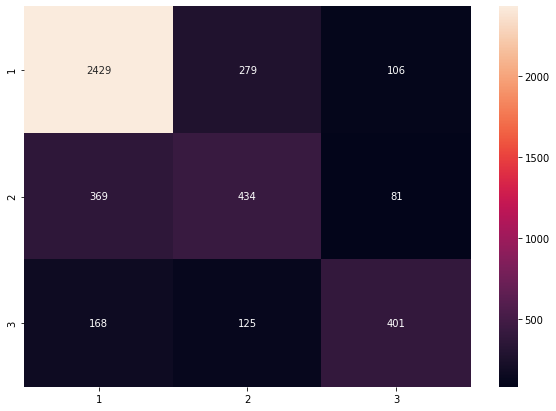

In [89]:
#Printing the confusion matrix
conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
#Based on the Accuracy score, Logistic Regression with TfidfVextorizer as vectoriztion should be selected as the best among these.